## IFT6135: Assigment # 1

#### By Amlin Charles, Georgina Jiménez, Alejandra Jiménez Nieto, and Charles C. Onu.

## Problem #2: Classifying MNIST handwritten digits with ConvNets

In this exercise, we follow the tutorial reference provided by the TAs for the structure of our CNN model (https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch). We also use the PyTorch Library to build and  train the model.

In [29]:
import time
import numpy as np
from __future__ import print_function

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [31]:
import torchvision
import torchvision.transforms

In [32]:
import matplotlib.pyplot as plt

#### Define image transformations &  Initialize datasets

In [33]:
mnist_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transforms, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transforms, download=True)

#### Create multi-threaded DataLoaders

In [34]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=500, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=True, num_workers=2)

#### Main classifier that subclasses nn.Module
##### We have 4 Conv2D layers, each follow by Dropout, ReLU activation and pooling layers.

In [37]:
class Classifier(nn.Module):
    """Convnet Classifier for MLP-like structure"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=36, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=36, out_channels=72, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=72, out_channels=144, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=144, out_channels=288, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(288, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())


##### Checking if we have a GPU available.

In [39]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


##### Defining our optimizer and the learning rate for the Gradient descent algorithm.

In [47]:
clf = Classifier()
if cuda_available:
    clf = clf.cuda()
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

#### Training of the model (up to 50 epochs)

In [42]:
num_epochs = 50
ep, train_error, valid_error = [], [], []
for epoch in range(num_epochs):
    losses = []
    ep.append(epoch+1)
  
    # Train
    total_train = 0
    correct_train = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if cuda_available:
                    inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.data.item())

        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets.data).cpu().sum()
        
        '''if batch_idx%num_epochs==0:
            print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))'''
            
    train_error.append(100-100.*correct_train/total_train)
    
    '''total_train = total_train
    correct_train = correct_train'''
    
    # Evaluate
    clf.eval()
    
    total_valid = 0
    correct_valid = 0
    
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if cuda_available:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_valid += targets.size(0)
        correct_valid += predicted.eq(targets.data).cpu().sum()

    valid_error.append(100-100.*correct_valid/total_valid)
    
    print('Epoch: %d --> Train Acc.: %.3f, Test Acc.: %.3f' % (epoch+1, 100.*correct_train/total_train, 100.*correct_valid/total_valid))
    print('---------------------------------------------------')
    
    clf.train()

Epoch: 1 --> Train Acc.: 50.000, Test Acc.: 80.000
---------------------------------------------------
Epoch: 2 --> Train Acc.: 83.000, Test Acc.: 91.000
---------------------------------------------------
Epoch: 3 --> Train Acc.: 89.000, Test Acc.: 93.000
---------------------------------------------------
Epoch: 4 --> Train Acc.: 92.000, Test Acc.: 95.000
---------------------------------------------------
Epoch: 5 --> Train Acc.: 93.000, Test Acc.: 95.000
---------------------------------------------------
Epoch: 6 --> Train Acc.: 94.000, Test Acc.: 96.000
---------------------------------------------------
Epoch: 7 --> Train Acc.: 94.000, Test Acc.: 96.000
---------------------------------------------------
Epoch: 8 --> Train Acc.: 95.000, Test Acc.: 97.000
---------------------------------------------------
Epoch: 9 --> Train Acc.: 95.000, Test Acc.: 97.000
---------------------------------------------------
Epoch: 10 --> Train Acc.: 95.000, Test Acc.: 97.000
---------------------

##### Structure of the trained model.

In [43]:
print(clf.eval())

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(36, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.5)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(72, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.5)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(144, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Dropout(p=0.5)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=288, out_features=10, bias=True)
)


#### Plotting the training and validation errors

([<matplotlib.axis.XTick at 0x14787b26b70>,
 <a list of 49 Text xticklabel objects>)

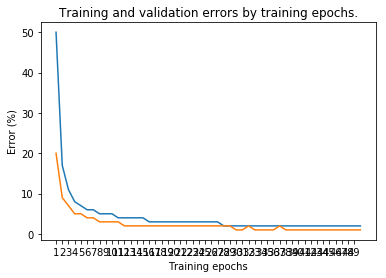

In [44]:
plt.plot(ep, train_error)
plt.plot(ep, valid_error)
plt.ylabel("Error (%)")
plt.xlabel("Training epochs")
plt.title('Training and validation errors by training epochs.')
#ax.set_xticklabels([''] + v)
plt.xticks(np.arange(min(ep), max(ep), 1))
#plt.yticks(np.arange(min(v)*100, max(v)*100, 0.05))

More fancy (with labels)

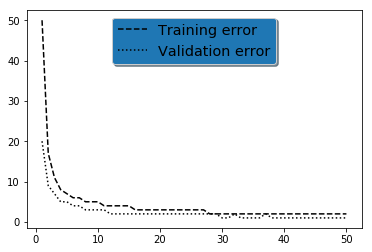

In [45]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(ep, train_error, 'k--', label='Training error')
ax.plot(ep, valid_error, 'k:', label='Validation error')
#ax.plot(a, c + d, 'k', label='Total message length')

'''ax.get_xlabel()
ax.get_ylabel("Accuracy (%)")
#ax.get_xlabel("Training epochs")
ax.title('Training and validation errors by training epochs.')
#ax.set_xticklabels([''] + v)
ax.xticks(np.arange(min(ep), max(ep), 1))'''

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

##### Getting vector of results ready for LaTeX report.

In [46]:
ep_train_err, ep_valid_err = [],[]
train_err_list=""
valid_err_list=""

for val in range(len(ep)):
    ep_train_err.append((ep[val], float(train_error[val])))
    ep_valid_err.append((ep[val], float(valid_error[val])))
    train_err_list= train_err_list + "(" + str(ep[val]) + ", " + str(float(train_error[val])) + ")"
    valid_err_list= valid_err_list + "(" + str(ep[val]) + ", " + str(float(valid_error[val])) + ")"
    
#print("Epochs: ",ep)
print("Training error: ", ep_train_err)
print("Validation error: " , ep_valid_err)
print("Training error: ", train_err_list)
print("Validation error: " , valid_err_list)

Training error:  [(1, 50.0), (2, 17.0), (3, 11.0), (4, 8.0), (5, 7.0), (6, 6.0), (7, 6.0), (8, 5.0), (9, 5.0), (10, 5.0), (11, 4.0), (12, 4.0), (13, 4.0), (14, 4.0), (15, 4.0), (16, 3.0), (17, 3.0), (18, 3.0), (19, 3.0), (20, 3.0), (21, 3.0), (22, 3.0), (23, 3.0), (24, 3.0), (25, 3.0), (26, 3.0), (27, 3.0), (28, 2.0), (29, 2.0), (30, 2.0), (31, 2.0), (32, 2.0), (33, 2.0), (34, 2.0), (35, 2.0), (36, 2.0), (37, 2.0), (38, 2.0), (39, 2.0), (40, 2.0), (41, 2.0), (42, 2.0), (43, 2.0), (44, 2.0), (45, 2.0), (46, 2.0), (47, 2.0), (48, 2.0), (49, 2.0), (50, 2.0)]
Validation error:  [(1, 20.0), (2, 9.0), (3, 7.0), (4, 5.0), (5, 5.0), (6, 4.0), (7, 4.0), (8, 3.0), (9, 3.0), (10, 3.0), (11, 3.0), (12, 2.0), (13, 2.0), (14, 2.0), (15, 2.0), (16, 2.0), (17, 2.0), (18, 2.0), (19, 2.0), (20, 2.0), (21, 2.0), (22, 2.0), (23, 2.0), (24, 2.0), (25, 2.0), (26, 2.0), (27, 2.0), (28, 2.0), (29, 2.0), (30, 1.0), (31, 1.0), (32, 2.0), (33, 1.0), (34, 1.0), (35, 1.0), (36, 1.0), (37, 2.0), (38, 1.0), (39, 1.0